## Data Summary  
#### Import Python Lirbaries

In [4]:
# import kagglehub
# # Log into Kaggle to access dataset
# kagglehub.login()

In [5]:
# # Import data to colab cache
# print('Downloading data from Kaggle...')
# histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')
# print('Data source import complete.\n')

# # Move from cache to colab content folder
# print('Moving data to ./content/ directory...')
# !cp -r /root/.cache/kagglehub/competitions/histopathologic-cancer-detection/* /content/
# print('Data moved successfully.')

In [99]:
# Import core libraries and ML utilities
import os
import glob
import gc
import random
import math
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

#### Import Datasets

In [2]:
# Paths to data folders and labels file
train_images_path = './train/'
test_images_path  = './test/'
train_labels_csv  = './train_labels.csv'

# train_images_path = '/content/train/'
# test_images_path  = '/content/test/'
# train_labels_csv  = '/content/train_labels.csv'

# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a list of the file paths to the images in the train and test folders
train_file_paths = glob.glob(os.path.join(train_images_path, '*.tif'))
test_file_paths = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_file_paths):,}\nCount of test images = {len(test_file_paths):,}')

Count of train images = 220,025
Count of test images = 57,458


In [ ]:
# Image config
IMG_SIZE = 96 # Target size to resize images to
CHANNELS = 3  # RGB images
SAMPLE_SIZE = 100 # Number of image samples used for training

# Tensorflow pipeline config
GPU_dict = {'RTX 3050 Ti':50, 'GC T4 GPU':80, 'GC TPU':64} # Dictionary used to choose GPU type (Local GPU vs Google Colab GPU/TPU)
SHARD_SIZE = round(len(train_file_paths) / GPU_dict['RTX 3050 Ti']) # The number of tf.train.Examples per TFRecord shard
BATCH_SIZE = 64 # Training batch size
AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism

#### Check Image Sizes
- Ensure all of the images are 96 x 96 pixels with 3 channels (red, green, blue)

In [ ]:
skip = True
def check_image_sizes(folder):
    bad_files = []
    if skip == False:
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            with tiff.TiffFile(path) as img:
                h, w, c = img.pages[0].shape
            if h != IMG_SIZE or w != IMG_SIZE or c != CHANNELS:
                bad_files.append(f)
    if len(bad_files)<=0 or skip==True:
        print(f'All {len(os.listdir(folder)):,} .tif files in the {folder} folder are {IMG_SIZE} x {IMG_SIZE} pixels with {CHANNELS} channels.')
    else:
        print(f"Found {len(bad_files)} files not matching image sizes of {IMG_SIZE} x {IMG_SIZE} x {CHANNELS}:")
        print(bad_files)

check_image_sizes(train_images_path)
check_image_sizes(test_images_path)

## Exploratory Data Analysis (EDA)

In this section we inspect the data visually and numerically.  We load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, we use the Pillow library to read them.  We also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive).  To mitigate bias during training, you may explore class weighting or resampling strategies.

#### Sample of Training Data Images
- something here ...

In [ ]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

#### Visualize RGB Channels
- Plot the red, green, blue channels from a random training .tif file

In [ ]:
# Randomly select a training image
rand_idx = random.randint(0, len(os.listdir(train_images_path))+1)
filename = os.listdir(train_images_path)[rand_idx]

# Path to one example image
img_path = os.path.join(train_images_path, filename)

# Read the image (as NumPy array)
img = tiff.imread(img_path)

# Display each channel with its color
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Original', 'Red Channel', 'Green Channel', 'Blue Channel']
cmaps  = [None, 'Reds_r', 'Greens_r', 'Blues_r']

# Plot original RGB + individual color channels
axes[0].imshow(img)
axes[0].set_title(titles[0])
axes[0].axis('off')
for i, (title, cmap) in enumerate(zip(titles[1:], cmaps[1:])):
    axes[i+1].imshow(img[:, :, i], cmap=cmap)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')
plt.tight_layout()
plt.suptitle(f'RGB Images for file: {filename}', y=1.1, horizontalalignment='right')
plt.show()

> Something about these RGB images...

#### RGB Histograms by Label
- Plot of distributions by label type

In [ ]:
# Choose a random set of files from the positive (1) and negative (0) labels
n = 50
positive_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==1]['id'].sample(n).to_list()]
negative_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==0]['id'].sample(n).to_list()]

# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
negative_files_hist_data = get_histogram_data(negative_files)
positive_files_hist_data = get_histogram_data(positive_files)

negative_files_probability_data = negative_files_hist_data / negative_files_hist_data.sum(axis=1, keepdims=True)
positive_files_probability_data = positive_files_hist_data / positive_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(negative_files_probability_data[0], 'b', label='Blue')
ax0.plot(negative_files_probability_data[1], 'g', label='Green')
ax0.plot(negative_files_probability_data[2], 'r', label='Red')
ax0.set_title('Negative Samples (0)', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(positive_files_probability_data[0], 'b', label='Blue')
ax1.plot(positive_files_probability_data[1], 'g', label='Green')
ax1.plot(positive_files_probability_data[2], 'r', label='Red')
ax1.set_title('Positive Samples (1)', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms (n={n:,} samples)')
plt.tight_layout()
plt.show()

> Visual differences between positive and negative samples...

#### Distribution of Labels
- Understand balance of dataset

In [ ]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Count of Labels')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

> Dataset is imbalanced....

#### Analysis Plan

Based on the EDA, the following observations guide our analysis:

- The label distribution shows a moderate class imbalance; using class weights or oversampling may help the model focus on minority (positive) samples.
- The images have strong staining variability and sometimes contain artefacts; data augmentation (random flips, rotations, brightness/contrast adjustments) can improve generalisation.

**Analysis plan:**

1. Split the labelled data into training and validation sets (e.g. 80/20).
2. Preprocess images: resize to a common size (96×96), apply augmentations on the fly, and normalise by global channel statistics.
3. Create baseline CNN model and evaluate the models on the validation set using metrics appropriate for class imbalance (AUC, precision, recall, F1).
4. Tune hyperparameters such as learning rate, optimiser, dropout rate, batch size or number of layers. Analyze metrics of best model.
5. Train using CNN transfer learning models (ResNet50 and DenseNet169).
6. Compare the baseline to the hyperparameter tuned and transfer models

## CNN Modeling
- First create a baseline CNN model
- Then how I'm applying hyperparameter tuning to the baseline model
- Next I'll use pre-trained transfer models which are existing models we can use.
- Evaluation metrics will be created for each model.

#### Train - Validation Split
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into a training and validation set (80% training, 20% validation) in order to be able to test the performace of the CNN models.

#### Create Datasets
- Explain how datasets are created

In [89]:
# Load labels
train_labels_df = pd.read_csv('./train_labels.csv')

# Take random samples from the train_labels_df (to reduce training time)
train_labels_df = train_labels_df.sample(SAMPLE_SIZE)

# Training-Validation split
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, random_state=42, stratify=train_labels_df['label'])

# Create file paths list after train-validation split
train_paths = ['./train/' + id + '.tif' for id in train_df['id']]
val_paths   = ['./train/' + id + '.tif' for id in val_df['id']]

# Create label vectors after train-validation split
training_labels = train_df['label'].values
validation_labels = val_df['label'].values

# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = tiff.imread(path)       
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img.astype(np.float32)

#Function to load and preprocess each image
def load_image(path, label):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])  # static shape required by Keras
    label = tf.cast(label, tf.int32)
    return img, label

# Create training and validation tf.data.Dataset instances
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, training_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, validation_labels))

# Create training dataset
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Create validation dataset
val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

#### Model Fitting & Evaluations Helper Functions
- Explain model fit and evaluation functions

In [82]:
# Function used to fit the model
def fit_CNN_model(model, train_dataset, val_dataset, n_train=None, n_val=None, batch_size=BATCH_SIZE):
    # Create a checkpoint file which stores best model weights
    checkpoint_path = f'{model.name}_best_model.weights.h5'

    # Configure callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_AUC', mode='max', save_best_only=True, save_weights_only=True)
    ]
    # Fit CNN model
    if not os.path.exists(checkpoint_path):
        model.fit(
            train_dataset,
            epochs=10,
            steps_per_epoch=math.ceil(n_train / batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(n_val / batch_size),
            callbacks=callbacks,
            verbose=1,
        )
    # Load from directory if best model weights already exist
    else:
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')

# Function used to create evaluation outputs
def evaulation_outputs(model, validation_dataset):
    # Predict validation probabilites
    validation_probabilities = model.predict(validation_dataset, verbose=1).ravel()

    # Convert probabilites to binary labels
    validation_predicted_labels = (validation_probabilities >= 0.5).astype(np.int32)

    # Print AUC and classification report
    print(f'\nROC AUC: {roc_auc_score(validation_labels, validation_probabilities)}\n')
    print(classification_report(validation_labels, validation_predicted_labels, digits=4))

    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(
        confusion_matrix(validation_labels, validation_predicted_labels), 
        annot=True, 
        fmt='d',
        cmap='viridis',
        cbar=False,
        xticklabels=['Negative Samples (0)','Positive Samples (1)'],
        yticklabels=['Negative Samples (0)','Positive Samples (1)'],
        square=True
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Validation Confusion Matrix')
    plt.tight_layout()
    plt.show()

#### Baseline CNN Model

In [ ]:
# Function to create an instance of baseline CNN model
def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dropout_rate=0.3):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name='augmentation')

    x_in = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(x_in)
    x = aug(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Use GlobalAveragePooling2D instead of Flatten
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(x_in, out, name='baseline_cnn_model')
    return model

# Create the baseline model instance
baseline_cnn_model = build_baseline_cnn()
baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['AUC','accuracy']
)

# Display baseline model structure
baseline_cnn_model.summary()

Model: "baseline_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - AUC: 0.7441 - accuracy: 0.6885 - loss: 0.5842 - val_AUC: 0.8025 - val_accuracy: 0.7490 - val_loss: 0.5701
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - AUC: 0.8355 - accuracy: 0.7716 - loss: 0.4908 - val_AUC: 0.7613 - val_accuracy: 0.6850 - val_loss: 0.7269
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - AUC: 0.8440 - accuracy: 0.7796 - loss: 0.4793 - val_AUC: 0.8346 - val_accuracy: 0.7210 - val_loss: 0.6407
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - AUC: 0.8362 - accuracy: 0.7761 - loss: 0.4876 - val_AUC: 0.8302 - val_accuracy: 0.7605 - val_loss: 0.5409
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - AUC: 0.8532 - accuracy: 0.7881 - loss: 0.4635 - val_AUC: 0.8667 - val_accuracy: 0.7775 - val_loss: 0.4815
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - AUC: 0.8588 - accuracy: 0.7916 - loss: 0.4569 - val_AUC: 0.8618 - val_accuracy: 0.7905 - val_loss: 0.4595
Epoch 7/10
125/125 ━━━━━━━━━━━━━━

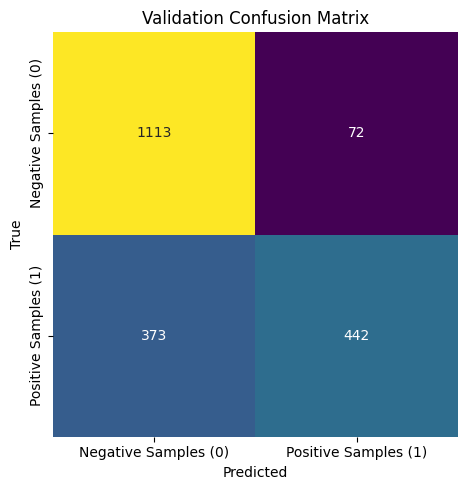

In [85]:
# Fit the baseline model
fit_CNN_model(
    baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(baseline_cnn_model, val_ds)

> Somthing about baseline model results...

## Hyperparmeter Tuning
- something about tuning....

#### Tuning Dropout & Learning Rates

In [111]:
def model_builder(hp):
    tf.keras.backend.clear_session()
    gc.collect()

    hp_learning_rate = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])
    hp_dropout = hp.Float('dropout', 0.3, 0.7, step=0.1)

    model = build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=hp_dropout)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    model_builder,
    objective=kt.Objective('val_AUC', direction='max'),
    max_trials=1,
    executions_per_trial=1,
    directory='tuner_dir',
    overwrite=True,
)

# Run tuner on base model
tuner.search(train_ds, validation_data=val_ds, epochs=5)

# Get best dropout and learning rates
best_learning_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
best_dropout_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('dropout')
print(f'\nAfter hyperparameter tuning the best learning rate is {best_learning_rate} and the best dropout rate is {best_dropout_rate}.')

Trial 1 Complete [00h 00m 04s]
val_AUC: 0.8020833134651184

Best val_AUC So Far: 0.8020833134651184
Total elapsed time: 00h 00m 04s

After hyperparameter tuning the best learning rate is 0.001 and the best dropout rate is 0.3.


#### Apply Best Learning & Dropout Rates to Baseline CNN Model

In [116]:
# Create the baseline model instance
tuned_baseline_cnn_model = build_baseline_cnn(dropout_rate=best_dropout_rate)
tuned_baseline_cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='binary_crossentropy',
    metrics=['AUC','accuracy']
)

# Display baseline model structure
tuned_baseline_cnn_model.summary()

Model: "baseline_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - AUC: 0.5706 - accuracy: 0.5750 - loss: 0.6856 - val_AUC: 0.7865 - val_accuracy: 0.6000 - val_loss: 0.6604
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.6080 - accuracy: 0.5875 - loss: 0.6708 - val_AUC: 0.8177 - val_accuracy: 0.6000 - val_loss: 0.6578
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUC: 0.6309 - accuracy: 0.5875 - loss: 0.6652 - val_AUC: 0.8542 - val_accuracy: 0.6000 - val_loss: 0.6677
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUC: 0.3578 - accuracy: 0.5375 - loss: 0.6987 - val_AUC: 0.7917 - val_accuracy: 0.6000 - val_loss: 0.6836
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - AUC: 0.5600 - accuracy: 0.5500 - loss: 0.6849 - val_AUC: 0.6667 - val_accuracy: 0.6000 - val_loss: 0.6863
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - AUC: 0.5983 - accuracy: 0.5750 - loss: 0.6860 - val_AUC: 0.6615 - val_accuracy: 0.6000 - val_loss: 0.6805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

ROC AUC: 0.8541666

/home/ryan-bulger/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryan-bulger/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryan-bulger/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

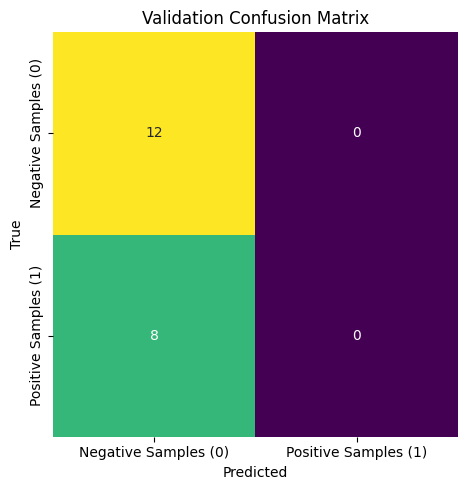

In [117]:
# Fit the baseline model
fit_CNN_model(
    tuned_baseline_cnn_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(tuned_baseline_cnn_model, val_ds)

## CNN Transfer Models
- Describe ResNet50 and DenseNet169 models...

#### Transfer Models Helper Function

In [ ]:


# Function to create a CNN transfer model
def build_transfer_model(base_model, input_shape, dropout_rate=best_dropout_rate):
    base_model.trainable = False  # freeze base model
    inputs = tf.keras.Input(shape=input_shape)
    # Apply augmentation layers directly
    x = tf.keras.layers.RandomFlip('horizontal')(inputs)
    x = tf.keras.layers.RandomRotation(0.2)(x)
    x = tf.keras.layers.RandomZoom(0.2)(x)
    x = tf.keras.layers.RandomContrast(0.1)(x)
    # Apply normalization
    x = tf.keras.layers.Rescaling(1./255)(x) # Using Rescaling layer for normalization
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        learning_rate=best_learning_rate,
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC','accuracy']
    )
    return model

#### ResNet50 CNN Transfer Model

In [ ]:
# ResNet50 model
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
resnet_model = build_transfer_model(resnet_model, dropout_rate=0.5)
resnet_model.summary()

In [ ]:
# Fit the ResNet50 transfer model
fit_CNN_model(
    resnet_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(resnet_model, val_ds)

#### DenseNet169 CNN Transfer Model

In [ ]:
# DenseNet169 transfer model
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
densenet_model = build_transfer_model(densenet_model, dropout_rate=0.5)
densenet_model.summary()

In [ ]:
# Fit the DenseNet169 transfer model
fit_CNN_model(
    resnet_model,
    train_ds,
    val_ds,
    n_train=len(training_labels),
    n_val=len(validation_labels),
    batch_size=BATCH_SIZE
)

# Create evaluation metrics
evaulation_outputs(resnet_model, val_ds)

## Results & Analysis
- Discuss and interpret results

#### Kaggle Submission

In [ ]:
# Get best model
# best_model =

# Predict labels for test images


# Convert prediction into Kaggle submission format
test_ids = []
test_probs = []
for batch_imgs, batch_ids in test_ds:
    p = baseline_cnn_model.predict(batch_imgs, verbose=0).ravel()
    test_probs.extend(p.tolist())
    test_ids.extend([i.decode() for i in batch_ids.numpy()])

sub = pd.DataFrame({'id': test_ids, 'label': test_probs})
sub = sub.sort_values('id').reset_index(drop=True)
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
# Image of Kaggle submission


## Conclusion
- Summarize project
- Learnings and takeaways
- What did and did not help improve the performance of your models
- What improvements could you try in the future